In [1]:

import os
import inspect
import sys
sys.path.insert(0, "../")


from experiment_information import *
from data import *
from helpers import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt



import pandas as pd
import numpy as np
import logging
import pprint
import re
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 1
# mpl.rcParams['legend.fontsize'] = 13

# mpl.rcParams['axes.titlesize'] = 15
# mpl.rcParams['axes.labelsize'] = 13
# mpl.rcParams['xtick.labelsize'] = 10
# mpl.rcParams['ytick.labelsize'] = 10


In [2]:
import numpy as np

In [3]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
# with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
with DatabaseHandler(logger,"../experiments/experiments.db") as dbHandler:

    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p_calibration"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p_calibration"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)

def explode_measures(df, new_columns, columns):
    for column in columns:
        def transform(column):
            # replace NaN in the column string by 0
            column = column.replace("NaN","0")
            # replace null in the column string by 0
            column = column.replace("null","0")
            # replace Infinity in the column string by np.inf
            column = column.replace("Infinity","np.inf")
            return eval(column)
        df[column] = df[column].apply(transform)

    exploded = df.explode(columns).reset_index(drop=True)

    for new_column, column in zip(new_columns, columns):
        if len(exploded[column].tolist()) > 0:
            exploded[["attack_epsilon",new_column]] = pd.DataFrame(exploded[column].tolist(), index=exploded.index)
        else:
            exploded[new_column] = np.nan
            # set attack_epsilon
            exploded["attack_epsilon"] = np.nan

    exploded = exploded.drop(columns=columns)
    return exploded


def explode_erm_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","adversarial_generalization_errors_overlap","fair_adversarial_errors","test_losses","boundary_loss_test_es"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","adversarial_generalization_error_overlap","fair_adversarial_error","test_loss","boundary_loss_test"]
    return explode_measures(df, new_columns, columns)

def explode_state_evolution_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","first_term_fair_errors","second_term_fair_errors","third_term_fair_errors","test_losses","data_model_adversarial_generalization_errors","gamma_robustness_es","boundary_loss_test_es"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","first_term_fair_error","second_term_fair_error","third_term_fair_error","test_loss","data_model_adversarial_generalization_error","gamma_robustness","boundary_loss_test"] #
    # columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","second_term_fair_errors","test_losses","data_model_adversarial_generalization_errors"]
    # new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","second_term_fair_error","test_loss","data_model_adversarial_generalization_error"] #
    return explode_measures(df, new_columns, columns)
    

df_erm = explode_erm_measures(df_erm)

df_state_evolution = explode_state_evolution_measures(df_state_evolution)
    

print("Current code version, ", __version__)

Current code version,  103


In [4]:
# load the dataframe from the pickle file
df_powerlaw = pd.read_pickle("Pickles/powerlaw.pkl")
df_powerlaw_beta = pd.read_pickle("Pickles/powerlaw_beta.pkl")

In [5]:
df_powerlaw_beta

index_state_evolution  \
                                                                                 mean   
alpha     epsilon tau  lam   problem_type attack_epsilon beta                           
1000000.0 0.0     0.05 0.001 Logistic     0.2            1.0100                2554.0   
                                                         1.0786                2576.0   
                                                         1.1472                2562.0   
                                                         1.2159                2579.0   
                                                         1.2845                2580.0   
                                                         1.3531                2559.0   
                                                         1.4217                2563.0   
                                                         1.4903                2569.0   
                                                         1.5590                2558.0   
                                                         1.6276                2573.0   
                                                         1.6962                2552.0   
                                                         1.7648                2557.0   
                                                         1.8334                2560.0   
                                                         1.9021                2561.0   
                                                         1.9707                2555.0   
                                                         2.0393                2556.0   
                                                         2.1079                2564.0   
                                                         2.1766                2574.0   
                                                         2.2452                2553.0   
                                                         2.3138                2565.0   
                                                         2.3824                2566.0   
                                                         2.4510                2567.0   
                                                         2.5197                2568.0   
                                                         2.5883                2577.0   
                                                         2.6569                2570.0   
                                                         2.7255                2572.0   
                                                         2.7941                2575.0   
                                                         2.8628                2578.0   
                                                         2.9314                2581.0   
                                                         3.0000                2582.0   
          0.2     0.05 0.001 Logistic     0.2            1.0100                2526.0   
                                                         1.0786                2529.0   
                                                         1.1472                2527.0   
                                                         1.2159                2530.0   
                                                         1.2845                2533.0   
                                                         1.3531                2528.0   
                                                         1.4217                2531.0   
                                                         1.4903                2532.0   
                                                         1.5590                2534.0   
                                                         1.6276                2535.0   
                                                         1.6962                2536.0   
                                                         1.7648                2537.0   
                                                         1.

In [6]:
df_powerlaw

index_state_evolution  \
                                                                                                                   mean   
alpha      epsilon tau  lam   problem_type attack_epsilon data_model_name                                                 
0.1585     0.0     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_0.5                2115.0   
                                                          KFeaturesModel_PowerLaw_Coefficient_1.5                2055.0   
                                                          KFeaturesModel_PowerLaw_Coefficient_2.5                2002.0   
                                                          KFeaturesModel_PowerLaw_Coefficient_3.5                1972.0   
           0.2     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_0.5                2116.0   
...                                                                                                                 ...   
10000.0000 0.0     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_3.5                2088.0   
           0.2     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_0.5                2180.0   
                                                          KFeaturesModel_PowerLaw_Coefficient_1.5                2141.0   
                                                          KFeaturesModel_PowerLaw_Coefficient_2.5                2129.0   
                                                          KFeaturesModel_PowerLaw_Coefficient_3.5                2078.0   

                                                                                                       \
                                                                                                  std   
alpha      epsilon tau  lam   problem_type attack_epsilon data_model_name                               
0.1585     0.0     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_0.5 NaN   
                                                          KFeaturesModel_PowerLaw_Coefficient_1.5 NaN   
                                                          KFeaturesModel_PowerLaw_Coefficient_2.5 NaN   
                                                          KFeaturesModel_PowerLaw_Coefficient_3.5 NaN   
           0.2     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_0.5 NaN   
...                                                                                                ..   
10000.0000 0.0     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_3.5 NaN   
           0.2     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_0.5 NaN   
                                                          KFeaturesModel_PowerLaw_Coefficient_1.5 NaN   
                                                          KFeaturesModel_PowerLaw_Coefficient_2.5 NaN   
                                                          KFeaturesModel_PowerLaw_Coefficient_3.5 NaN   

                                                                                                  duration_state_evolution  \
                                                                                                                      mean   
alpha      epsilon tau  lam   problem_type attack_epsilon data_model_name                                                    
0.1585     0.0     0.05 0.001 Logistic     0.2            KFeaturesModel_PowerLaw_Coefficient_0.5                 0.060791   
                                                          KFeaturesModel_PowerLaw_Coefficient_1.5                 0.143259   
                                                          KFeaturesModel_PowerLaw_Coefficient_2.5                 0.768748   
                                                          KFeaturesModel_PowerLaw_Coefficient_3.5                 3.032063   
           0.2     0.0

# Extracting Data

In [7]:
# extract unique epsilons
epsilons = df_powerlaw.index.get_level_values("epsilon").unique()
epsilons_beta = df_powerlaw_beta.index.get_level_values("epsilon").unique()
epsilons, epsilons_beta

(Index([0.0, 0.2], dtype='float64', name='epsilon'),
 Index([0.0, 0.2], dtype='float64', name='epsilon'))

In [8]:
# keep only attack_epsilon = 0.2
df_powerlaw = df_powerlaw.xs(0.2, level="attack_epsilon")
df_powerlaw_beta = df_powerlaw_beta.xs(0.2, level="attack_epsilon")

In [9]:
data_model_names = df_powerlaw.index.get_level_values("data_model_name").unique()
data_model_names

Index(['KFeaturesModel_PowerLaw_Coefficient_0.5',
       'KFeaturesModel_PowerLaw_Coefficient_1.5',
       'KFeaturesModel_PowerLaw_Coefficient_2.5',
       'KFeaturesModel_PowerLaw_Coefficient_3.5'],
      dtype='object', name='data_model_name')

In [10]:
# create a dictionary of dataframes for each data_model_name
df_dict_beta = {}
for data_model_name in data_model_names:

    # the data_model_name is given by a string of this form 'KFeaturesModel_PowerLaw_Coefficient_3.5'
    # we want to extract the coefficient
    # split the string by '_'
    split = data_model_name.split("_")
    # extract the coefficient
    beta = split[-1]
    # convert the beta to a float
    beta = float(beta)

    


    df_data_model = df_powerlaw.xs(data_model_name, level="data_model_name")

    # for each data_model_name, create a dictionary
    eps_dict = {}

    for epsilon in epsilons:


        eps_df = df_data_model.xs(epsilon, level="epsilon")

        alphas = eps_df.index.get_level_values("alpha").unique()
        adversarial_error_0 = eps_df["adversarial_generalization_error_state_evolution"]["mean"].values
        generalization_error_0 = eps_df["generalization_error_state_evolution"]["mean"].values
        boundary_error_0 = eps_df["difference_adv_gen_state_evolution"]["mean"].values
        class_preserving = eps_df["fair_adversarial_error_state_evolution"]["mean"].values

        adversarial_error_erm = eps_df["adversarial_generalization_error_erm"]["mean"].values
        generalization_error_erm = eps_df["generalization_error_erm_erm"]["mean"].values
        boundary_error_erm = eps_df["difference_adv_gen_erm"]["mean"].values
        class_preserving_erm = eps_df["fair_adversarial_error_erm"]["mean"].values

        adversarial_error_erm_std = eps_df["adversarial_generalization_error_erm"]["std"].values
        generalization_error_erm_std = eps_df["generalization_error_erm_erm"]["std"].values
        boundary_error_erm_std = eps_df["difference_adv_gen_erm"]["std"].values
        class_preserving_erm_std = eps_df["fair_adversarial_error_erm"]["std"].values

        alphas = np.array(alphas)
        adversarial_error_0 = np.array(adversarial_error_0)
        generalization_error_0 = np.array(generalization_error_0)
        boundary_error_0 = np.array(boundary_error_0)
        class_preserving = np.array(class_preserving)

        adversarial_error_erm = np.array(adversarial_error_erm)
        generalization_error_erm = np.array(generalization_error_erm)
        boundary_error_erm = np.array(boundary_error_erm)
        class_preserving_erm = np.array(class_preserving_erm)

        adversarial_error_erm_std = np.array(adversarial_error_erm_std)
        generalization_error_erm_std = np.array(generalization_error_erm_std)
        boundary_error_erm_std = np.array(boundary_error_erm_std)
        class_preserving_erm_std = np.array(class_preserving_erm_std)

        eps_0_dict = {}
        eps_0_dict["alphas"] = alphas
        eps_0_dict["adversarial_error"] = adversarial_error_0
        eps_0_dict["generalization_error"] = generalization_error_0
        eps_0_dict["boundary_error"] = boundary_error_0
        eps_0_dict["class_preserving"] = class_preserving

        eps_0_dict["adversarial_error_erm"] = adversarial_error_erm
        eps_0_dict["generalization_error_erm"] = generalization_error_erm
        eps_0_dict["boundary_error_erm"] = boundary_error_erm
        eps_0_dict["class_preserving_erm"] = class_preserving_erm

        eps_0_dict["adversarial_error_erm_std"] = adversarial_error_erm_std
        eps_0_dict["generalization_error_erm_std"] = generalization_error_erm_std
        eps_0_dict["boundary_error_erm_std"] = boundary_error_erm_std
        eps_0_dict["class_preserving_erm_std"] = class_preserving_erm_std


        eps_dict[epsilon] = eps_0_dict


    df_dict_beta[beta] = eps_dict


In [11]:
# create a dictionary of dataframes for each data_model_name
df_dict = {}
for epsilon in epsilons:

        


    eps_df = df_powerlaw_beta.xs(epsilon, level="epsilon")



    # for each data_model_name, create a dictionary
    eps_dict = {}


    betas = eps_df.index.get_level_values("beta").unique()
    adversarial_error_0 = eps_df["adversarial_generalization_error_state_evolution"]["mean"].values
    generalization_error_0 = eps_df["generalization_error_state_evolution"]["mean"].values
    boundary_error_0 = eps_df["difference_adv_gen_state_evolution"]["mean"].values
    class_preserving = eps_df["fair_adversarial_error_state_evolution"]["mean"].values

    adversarial_error_erm = eps_df["adversarial_generalization_error_erm"]["mean"].values
    generalization_error_erm = eps_df["generalization_error_erm_erm"]["mean"].values
    boundary_error_erm = eps_df["difference_adv_gen_erm"]["mean"].values
    class_preserving_erm = eps_df["fair_adversarial_error_erm"]["mean"].values

    adversarial_error_erm_std = eps_df["adversarial_generalization_error_erm"]["std"].values
    generalization_error_erm_std = eps_df["generalization_error_erm_erm"]["std"].values
    boundary_error_erm_std = eps_df["difference_adv_gen_erm"]["std"].values
    class_preserving_erm_std = eps_df["fair_adversarial_error_erm"]["std"].values

    betas = np.array(betas)
    adversarial_error_0 = np.array(adversarial_error_0)
    generalization_error_0 = np.array(generalization_error_0)
    boundary_error_0 = np.array(boundary_error_0)
    class_preserving = np.array(class_preserving)

    adversarial_error_erm = np.array(adversarial_error_erm)
    generalization_error_erm = np.array(generalization_error_erm)
    boundary_error_erm = np.array(boundary_error_erm)
    class_preserving_erm = np.array(class_preserving_erm)

    adversarial_error_erm_std = np.array(adversarial_error_erm_std)
    generalization_error_erm_std = np.array(generalization_error_erm_std)
    boundary_error_erm_std = np.array(boundary_error_erm_std)
    class_preserving_erm_std = np.array(class_preserving_erm_std)

    eps_0_dict = {}
    eps_0_dict["betas"] = betas
    eps_0_dict["adversarial_error"] = adversarial_error_0
    eps_0_dict["generalization_error"] = generalization_error_0
    eps_0_dict["boundary_error"] = boundary_error_0
    eps_0_dict["class_preserving"] = class_preserving

    eps_0_dict["adversarial_error_erm"] = adversarial_error_erm
    eps_0_dict["generalization_error_erm"] = generalization_error_erm
    eps_0_dict["boundary_error_erm"] = boundary_error_erm
    eps_0_dict["class_preserving_erm"] = class_preserving_erm

    eps_0_dict["adversarial_error_erm_std"] = adversarial_error_erm_std
    eps_0_dict["generalization_error_erm_std"] = generalization_error_erm_std
    eps_0_dict["boundary_error_erm_std"] = boundary_error_erm_std
    eps_0_dict["class_preserving_erm_std"] = class_preserving_erm_std





    df_dict[epsilon] = eps_0_dict


# Plotting

/Users/kasimirtanner/opt/anaconda3/envs/pdm/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


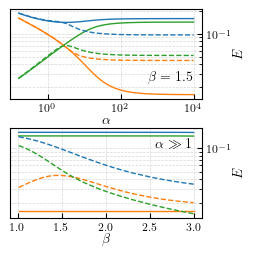

In [18]:

IMG_DIRECTORY = "./Assets/powerlaw_combined"
if not os.path.exists(IMG_DIRECTORY):
    os.makedirs(IMG_DIRECTORY)


def save_plot(fig, name, formats=["pdf","jpg"], date=False):
    current_date = datetime.datetime.now().strftime("%Y-%m-%d")
    for f in formats:        
        path = "{}".format(name) + "_{}".format(current_date) + "." + f
        if not date:
            path = "{}".format(name) + "." + f
        fig.savefig(            
            os.path.join(IMG_DIRECTORY, path),
            format=f,
        )


def set_size(width, fraction=1, subplots=(1, 1)):
    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27

    golden_ratio = (5**0.5 - 1) / 2

    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * (golden_ratio) * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


# width = 1.5 * 458.63788

multiplier = 1.25 
width = multiplier * 487.8225
multiplier = 1.25
width = multiplier * 1.5 * 234.8775

plt.style.use("../latex_ready.mplstyle")

tuple_size = set_size(width, fraction=0.50)
tuple_size = (2.375,2.4)

multiplier = 0.9
second_multiplier = 0.7


# import Line2D for custom legend
from matplotlib.lines import Line2D

fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=False,
    sharey=False,
    figsize=( tuple_size[0], tuple_size[1]),
    gridspec_kw={"hspace": 0.33,"wspace": 0},
)


# ICML adjustments
fig.subplots_adjust(left=0.01)
fig.subplots_adjust(bottom=0.12)
fig.subplots_adjust(top=0.99)
fig.subplots_adjust(right=0.82)
# plt.subplots_adjust(bottom=0.30)



# Create a custom legend
custom_legend = []

linestyles = ["solid", "dashed", "dashdot", "dotted"]


for epsilon_idx, epsilon in enumerate(epsilons):

    # ax = axes[epsilon_idx]
    ax = axes[0]

    for df_idx, (key, value) in enumerate(df_dict_beta.items()):

        beta = key


        eps_dict = value[epsilon]

        if beta == 0.5 or beta > 1.5:
            continue

        alphas = eps_dict["alphas"]
        adversarial_error = eps_dict["adversarial_error"]
        generalization_error = eps_dict["generalization_error"]
        boundary_error = eps_dict["boundary_error"]
        class_preserving = eps_dict["class_preserving"]

        adversarial_error_erm = eps_dict["adversarial_error_erm"]
        generalization_error_erm = eps_dict["generalization_error_erm"]
        boundary_error_erm = eps_dict["boundary_error_erm"]
        class_preserving_erm = eps_dict["class_preserving_erm"]

        adversarial_error_erm_std = eps_dict["adversarial_error_erm_std"]
        generalization_error_erm_std = eps_dict["generalization_error_erm_std"]
        boundary_error_erm_std = eps_dict["boundary_error_erm_std"]
        class_preserving_erm_std = eps_dict["class_preserving_erm_std"]


        adversarial_lines = ax.plot(alphas, adversarial_error, linestyle=linestyles[epsilon_idx],color="C0")
        ax.plot(alphas, generalization_error, linestyle=linestyles[epsilon_idx],color="C1")
        ax.plot(alphas, boundary_error,linestyle=linestyles[epsilon_idx], color="C2")
        # ax.plot(alphas, class_preserving,linestyle=linestyles[df_idx], color="C3")

        custom_legend.append(Line2D([0],[0],color="C0", linestyle=linestyles[df_idx]))
        custom_legend.append(Line2D([0],[0],color="C1", linestyle=linestyles[df_idx]))
        custom_legend.append(Line2D([0],[0],color="C2", linestyle=linestyles[df_idx]))
        # custom_legend.append(Line2D([0],[0],color="C3", linestyle=linestyles[df_idx]))

        ax.errorbar(
            alphas,
            adversarial_error_erm,
            yerr=adversarial_error_erm_std,
            fmt=".",
            markersize=1,
            color="C0"
        )
        ax.errorbar(
            alphas,
            generalization_error_erm,
            yerr=generalization_error_erm_std,
            fmt=".",
            markersize=1,
            color="C1"
        )
        ax.errorbar(
            alphas,
            boundary_error_erm,
            yerr=boundary_error_erm_std,
            fmt=".",
            markersize=1,
            color="C2"
        )
        # axs.errorbar(
        #     alphas,
        #     class_preserving_erm,
        #     yerr=class_preserving_erm_std,
        #     fmt=".",
        #     markersize=1,
        #     color="C3"
        # )

    ax.legend(title=f"$\\beta={1.5}$",framealpha=0)
    # Set the major ticks to face inwards
    ax.tick_params(axis='both', which='major', direction='in')

    # Set the minor ticks to face inwards
    ax.tick_params(axis='both', which='minor', direction='in')

    ax.set_xscale("log")
    ax.set_yscale("log")




    ax.set_ylabel(r"$E$", labelpad=0.5)
    ax.set_xlabel(r"$\alpha$", labelpad=0.1)
    ax.grid(which="both", axis="both", alpha=0.5)

    # put the ylabel to the right
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    


    ax = axes[1]


    eps_dict = df_dict[epsilon]


    betas = eps_dict["betas"]
    adversarial_error = eps_dict["adversarial_error"]
    generalization_error = eps_dict["generalization_error"]
    boundary_error = eps_dict["boundary_error"]
    class_preserving = eps_dict["class_preserving"]

    adversarial_error_erm = eps_dict["adversarial_error_erm"]
    generalization_error_erm = eps_dict["generalization_error_erm"]
    boundary_error_erm = eps_dict["boundary_error_erm"]
    class_preserving_erm = eps_dict["class_preserving_erm"]

    adversarial_error_erm_std = eps_dict["adversarial_error_erm_std"]
    generalization_error_erm_std = eps_dict["generalization_error_erm_std"]
    boundary_error_erm_std = eps_dict["boundary_error_erm_std"]
    class_preserving_erm_std = eps_dict["class_preserving_erm_std"]


    adversarial_lines = ax.plot(betas, adversarial_error, linestyle=linestyles[epsilon_idx],color="C0")
    ax.plot(betas, generalization_error, linestyle=linestyles[epsilon_idx],color="C1")
    ax.plot(betas, boundary_error,linestyle=linestyles[epsilon_idx], color="C2")


    # ax.set_xscale("log")
    ax.set_yscale("log")


    ax.set_ylabel(r"$E$", labelpad=0.5)
    ax.set_xlabel(r"$\beta$", labelpad=0.1)
    ax.grid(which="both", axis="both", alpha=0.5)

    # put the ylabel to the right
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()


    # Set the major ticks to face inwards
    ax.tick_params(axis='both', which='major', direction='in')

    # Set the minor ticks to face inwards
    ax.tick_params(axis='both', which='minor', direction='in')
    ax.legend(title=f"$\\alpha\\gg1$",loc="upper right",framealpha=0)



error_legend = []

error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{adv}}$",color="C0"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{gen}}$",color="C1"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{bound}}$",color="C2"))
# error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{CP}}$",color="C3"))

epsilon_legend = []

for idx, (beta, value) in enumerate(df_dict.items()):
    epsilon_legend.append(Line2D([0],[0],color="black", linestyle=linestyles[idx], label=r"$\beta={}$".format(beta))) 


custom_legend = []

# mix the two legends
for idx in range(len(error_legend)):
    
    # custom_legend.append(epsilon_legend[idx+1])
    custom_legend.append(error_legend[idx])

# custom_legend.append(epsilon_legend[-1])

# Place the legend at the bottom of the figure
# fig.legend(handles=custom_legend, loc='upper center', ncol=3, handlelength=1)

fig.align_labels()

save = True
if save:
    save_plot(
        fig,
        f"powerlaw_combined",
    )

plt.show()


